
Successfully saved authorization token.


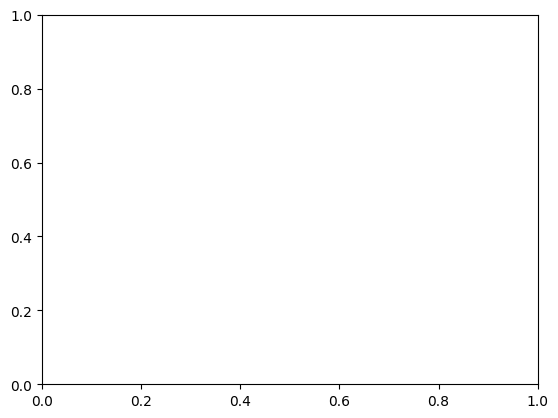

In [5]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import random
import ee

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define the wildfire location and node distance
wildfire_lat = 39.819
wildfire_lon = -121.419
node_dist = .0009

# Initialize the scheduler and burned sets
scheduler = {
    0: {(wildfire_lon, wildfire_lat)}
}
burned = set()

# Task tracking
last_task = 0
cur_task = 0

# Earth Engine datasets
image_elevation = ee.Image("NASA/NASADEM_HGT/001").select('elevation')
image_temperature = ee.ImageCollection("MODIS/061/MOD11A1").select('LST_Day_1km')
image_biomass = ee.ImageCollection("WCMC/biomass_carbon_density/v1_0").select('carbon_tonnes_per_ha')

# Function to get dataset values
def dataset_value(dataset, lon, lat):
    point = ee.Geometry.Point([lon, lat])
    if isinstance(dataset, ee.imagecollection.ImageCollection):
        dataset = dataset.mean()
    value = dataset.reduceRegion(
        reducer=ee.Reducer.first(), 
        geometry=point, 
        scale=30
    ).getInfo()
    return value

# Probability and time calculation functions
def calc_prob(node1, node2):
    elevation1 = dataset_value(image_elevation, *node1)['elevation']
    elevation2 = dataset_value(image_elevation, *node2)['elevation']
    temp1 = dataset_value(image_temperature, *node1)['LST_Day_1km']
    temp2 = dataset_value(image_temperature, *node2)['LST_Day_1km']
    biomass1 = dataset_value(image_biomass, *node1)['carbon_tonnes_per_ha']
    biomass2 = dataset_value(image_biomass, *node2)['carbon_tonnes_per_ha']

    elevation_factor = abs(elevation1 - elevation2)
    temperature_factor = abs(temp1 - temp2)
    biomass_factor = abs(biomass1 - biomass2)

    pn = 0.5
    alpha_wh = 1 + elevation_factor * 0.1
    em = 1 + temperature_factor * 0.01 - biomass_factor * 0.01

    pij = (1 - (1 - pn) ** alpha_wh) * em
    return pij

def calc_time(node1, node2):
    elevation1 = dataset_value(image_elevation, *node1)['elevation']
    elevation2 = dataset_value(image_elevation, *node2)['elevation']
    temp1 = dataset_value(image_temperature, *node1)['LST_Day_1km']
    temp2 = dataset_value(image_temperature, *node2)['LST_Day_1km']
    biomass1 = dataset_value(image_biomass, *node1)['carbon_tonnes_per_ha']
    biomass2 = dataset_value(image_biomass, *node2)['carbon_tonnes_per_ha']

    elevation_factor = abs(elevation1 - elevation2)
    temperature_factor = abs(temp1 - temp2)
    biomass_factor = abs(biomass1 - biomass2)

    d = 1
    vprop_base = 1
    vprop = vprop_base + elevation_factor * 0.05 - temperature_factor * 0.01 + biomass_factor * 0.02

    delta_t = d / vprop
    return delta_t

# Visualization function adapted for animation
def visualize_fire(frame):
    global scheduler, burned, last_task, cur_task
    ax.clear()

    x_min, x_max = -121.43, -121.41
    y_min, y_max = 39.81, 39.83
    grid_x, grid_y = np.mgrid[x_min:x_max:node_dist, y_min:y_max:node_dist]
    grid = np.zeros(grid_x.shape, dtype=int)

    for burned_node in burned:
        grid[int((burned_node[0] - x_min) / node_dist), int((burned_node[1] - y_min) / node_dist)] = 2

    if frame in scheduler:
        for node in scheduler[frame]:
            grid[int((node[0] - x_min) / node_dist), int((node[1] - y_min) / node_dist)] = 1

    ax.imshow(grid.T, cmap='hot', origin='lower', extent=[x_min, x_max, y_min, y_max])
    ax.set_title(f'Wildfire Spread Simulation at Step {frame}')
    ax.set_xlabel('Longitude')

fig, ax = plt.subplots()

# Initialize the animation
ani = FuncAnimation(fig, visualize_fire, frames=range(last_task + 1), interval=1000)

# Display the animation in a Jupyter Notebook
plt.show()
